#Import Adult Dataset

In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

#Upload custom dataset

In [ ]:
from google.colab import files

files.upload()      # Upload the training data csv. The following implementation drops the null values. Custom handling before uploading is encouraged
dataset_name = '...'      # use the name .csv file imported above
attributes_to_ignore = []     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = []

In [ ]:
import pandas as pd

train_data = pd.read_csv(dataset_name)
train_data = train_data.dropna()
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data.head()

# Step evaluation functions

In [ ]:
from scipy.stats import wasserstein_distance


def get_cat_wasserstein_distances(real_data, ctgan_data, column_name):
        real_rel = real_data.groupby(column_name).size().values
        total = sum(real_rel)
        real_rel = real_rel/total

        ctgan_rel = ctgan_data.groupby(column_name).size().values
        total = sum(ctgan_rel)
        ctgan_rel = ctgan_rel/total

        ctgan_distance = wasserstein_distance(real_rel, ctgan_rel)

        return ctgan_distance

In [ ]:
def avg_cat_w_dist(real_data, ctgan_data, discrete_columns):
    dists = 0
    for c in discrete_columns:
        dists += get_cat_wasserstein_distances(real_data, ctgan_data, c)
    avg_dists = dists/len(discrete_columns)
    return avg_dists

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data, numerical_columns):
    dists = 0
    for c in numerical_columns:
        dists += wasserstein_distance(real_data[c], model_data[c])
    avg_dists = dists/len(numerical_columns)
    return avg_dists

In [ ]:
import numpy as np

def L2_of_numerical_correlation_matrices(real_data, model_data, cols):
        # Compute correlation matrices
        df1 = real_data[cols]
        df2 = model_data[cols]
        corr1 = df1[cols].corr().values
        corr2 = df2[cols].corr().values

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance



#TVAE Synthesizer

In [ ]:
#upload the 'transformer.py' and 'data_sampler.py'
from google.colab import files
files.upload()

In [ ]:
!pip install rdt torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
# Implementation of the TVAE synthesizer
# GitHub repository: https://github.com/sdv-dev/CTGAN
# Paper: https://arxiv.org/abs/1907.00503

"""TVAE module."""

import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, Module, Parameter, ReLU, Sequential
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from transformer import DataTransformer


class Encoder(Module):
    """Encoder for the TVAE.

    Args:
        data_dim (int):
            Dimensions of the data.
        compress_dims (tuple or list of ints):
            Size of each hidden layer.
        embedding_dim (int):
            Size of the output vector.
    """

    def __init__(self, data_dim, compress_dims, embedding_dim):
        super(Encoder, self).__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, embedding_dim)
        self.fc2 = Linear(dim, embedding_dim)

    def forward(self, input_):
        """Encode the passed `input_`."""
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    """Decoder for the TVAE.

    Args:
        embedding_dim (int):
            Size of the input vector.
        decompress_dims (tuple or list of ints):
            Size of each hidden layer.
        data_dim (int):
            Dimensions of the data.
    """

    def __init__(self, embedding_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        """Decode the passed `input_`."""
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, output_info, factor):
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax':
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st])
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum'
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss) * factor / x.size()[0], KLD / x.size()[0]


class TVAE():
    """TVAE."""

    def __init__(
        self,
        embedding_dim=128,
        compress_dims=(1024, 512, 256),
        decompress_dims=(256, 512, 1024),
        l2scale=1e-5,
        batch_size=4000,
        epochs=600,
        loss_factor=2,
        cuda=True,
        verbose=False,
    ):
        self.embedding_dim = embedding_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims

        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        self.verbose = verbose

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

    #random_state
    def fit(self, train_data, discrete_columns=()):

        train_df = train_data.copy()
        self.avg_cat_w_distances = []
        self.avg_num_w_distances = []
        self.corr_l2_distances = []
        num_columns = [c for c in train_df.columns if c not in discrete_columns]

        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        train_data = self.transformer.transform(train_data)
        dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)

        data_dim = self.transformer.output_dimensions
        encoder = Encoder(data_dim, self.compress_dims, self.embedding_dim).to(self._device)
        self.decoder = Decoder(self.embedding_dim, self.decompress_dims, data_dim).to(self._device)
        optimizerAE = Adam(
            list(encoder.parameters()) + list(self.decoder.parameters()), weight_decay=self.l2scale
        )

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        iterator = tqdm(range(self.epochs), disable=(not self.verbose))
        if self.verbose:
            iterator_description = 'Loss: {loss:.3f}'
            iterator.set_description(iterator_description.format(loss=0))

        for i in iterator:
            loss_values = []
            batch = []
            for id_, data in enumerate(loader):
                optimizerAE.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                    self.loss_factor,
                )
                loss = loss_1 + loss_2
                loss.backward()
                optimizerAE.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)

                batch.append(id_)
                loss_values.append(loss.detach().cpu().item())

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i] * len(batch),
                'Batch': batch,
                'Loss': loss_values,
            })
            if i%10==0:
              print(i)
              curr_samples = self.sample(1000)
              self.avg_cat_w_distances.append(avg_cat_w_dist(train_df, curr_samples, discrete_columns))
              self.avg_num_w_distances.append(avg_num_w_dist(train_df, curr_samples, num_columns))
              self.corr_l2_distances.append(L2_of_numerical_correlation_matrices(train_df, curr_samples, num_columns))


            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            if self.verbose:
                iterator.set_description(
                    iterator_description.format(loss=loss.detach().cpu().item())
                )

        return self.avg_cat_w_distances, self.avg_num_w_distances, self.corr_l2_distances

    #random_state
    def sample(self, samples):

        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.embedding_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)

#Training

In [ ]:
tvae = TVAE()

res = tvae.fit(train_data, discrete_columns)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


#Plotting progression graphs

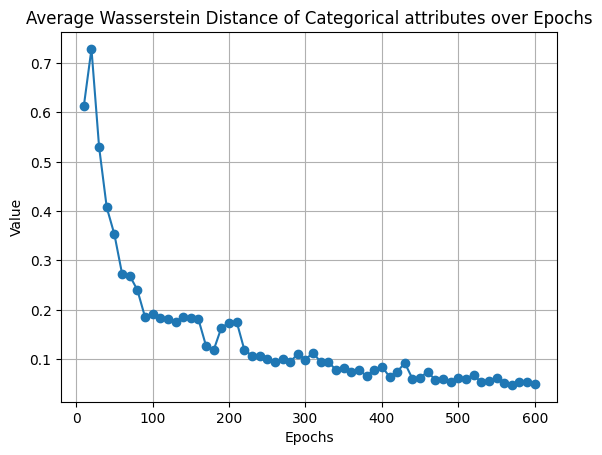

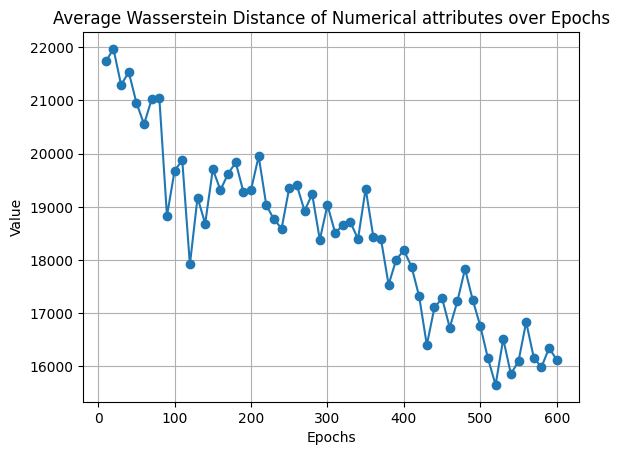

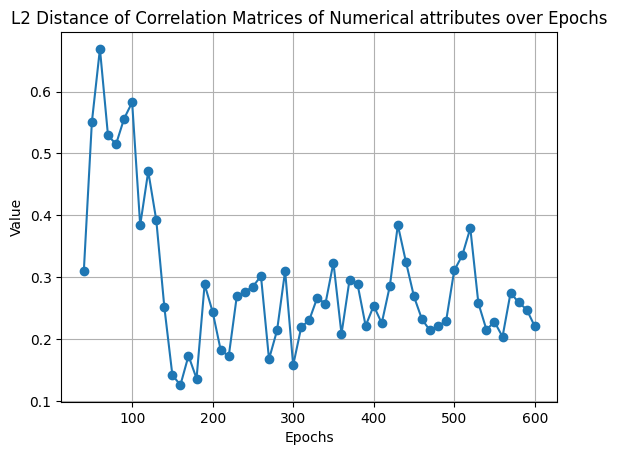

In [ ]:
import matplotlib.pyplot as plt

values = res[0]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Categorical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[1]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[2]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Generating and saving samples

In [ ]:
samples = tvae.sample(5000)

In [ ]:
samples

In [ ]:
samples.to_csv('tvae_samples.csv')
files.download('tvae_samples.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>